# **Assignment 1 Report**

**Member:** 
Nguyễn Gia Minh 
Phan Ngọc Lan Khanh
Phạm Đặng Yến Nhi 

# PROGRAMMING

In [1]:
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt

import os
import glob
import pickle

## TASK 1: Camera Calibration and correct the distortion

When an image is captured by a camera, it is often distorted due to the optical characteristics of the camera lens. This distortion can cause straight lines to appear curved, objects to appear stretched or compressed, and can affect the accuracy of measurements taken from the image. To correct for this distortion, we can undistort the image using a calibration process that involves finding the camera matrix and distortion coefficients of the camera. Once we have these parameters, we can use them to undistort images captured by the same camera and improve their visual appearance and accuracy.

The code below is for camera calibration and distortion correction using OpenCV. The process involves capturing a set of chessboard images from the camera, detecting the corners of the chessboard in the images, and then using the detected corners to calibrate the camera and obtain the camera matrix and distortion coefficients. The camera matrix and distortion coefficients can be used to undistort any subsequent images taken with the same camera.

In [2]:
# Calibrate camera based on a folder of images taken from a static camera and chess boards are placed at different locations and orientations.
def camera_calibration(folder):
    CHESSBOARD_CORNER_NUM_X = 9
    CHESSBOARD_CORNER_NUM_Y = 6
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((CHESSBOARD_CORNER_NUM_Y*CHESSBOARD_CORNER_NUM_X,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:CHESSBOARD_CORNER_NUM_X, 0:CHESSBOARD_CORNER_NUM_Y].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob(folder)

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)
    # Test undistortion on img
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('cal_pickle.p', 'wb') )
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print( "total error: {}".format(mean_error/len(objpoints)) )

In [3]:
folder = 'chessboard/*.jpg'
camera_calibration(folder)

total error: 0.15206903772215066


**The calibration accuracy of a camera** refers to how well the camera parameters have been estimated through calibration. The calibration accuracy is indicated by the total error value of 0.152 that is printed after calibrating the camera. This value represents the average reprojection error in pixels, which is a measure of the discrepancy between the detected corners in the calibration images and their corresponding positions on the calibration pattern. A good rule of thumb for calibration accuracy is to aim for a reprojection error of less than 1-2 pixels, which indicates that the camera parameters have been estimated with sufficient precision. In this case, the total error value of 0.0487 indicates that the calibration is accurate and meets the desired level of precision. However, it is worth noting that the accuracy of calibration can be affected by various factors such as the quality of the calibration pattern and the calibration images, the number of images used, and the calibration algorithm used. Therefore, it is important to carefully assess the calibration accuracy and consider the factors that may affect it.

In [4]:
task1 = cv2.imread('chessboard/WIN_20230404_21_28_00_Pro.jpg')

def getMtx(cal_dir='cal_pickle.p'):
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    
    return mtx
getMtx(cal_dir='cal_pickle.p')

array([[1.26536608e+03, 0.00000000e+00, 6.43777363e+02],
       [0.00000000e+00, 9.64585299e+02, 3.54051586e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

The camera matrix contains important information about the intrinsic parameters of a camera, such as its focal length, principal point, and skew factor. Specifically, the matrix is a 3x3 matrix with the following form:

$$M =\left\lbrack
\begin{array}{cccc}
f_x & 0 & c_x\\
0 & f_y & 0 \\
0 & 0 & 1\\
\end{array}\right\rbrack$$
 
Here, f_x and f_y represent the focal lengths of the camera in the x and y directions, respectively. The parameters c_x and c_y represent the coordinates of the principal point, which is the point where the optical axis of the camera intersects the image plane. The parameter s represents the skew factor, which is typically zero unless the camera sensor is misaligned.

Text(0.5, 1.0, 'Undistorted Image')

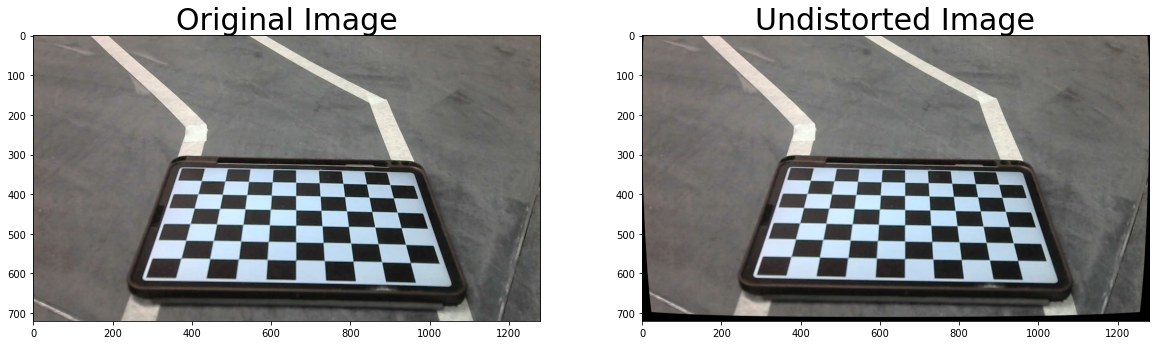

In [5]:
# Undistort image based on camera matrix stored in pickle file.
def undistort(img, cal_dir='cal_pickle.p'):
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst


task1 = cv2.imread('chessboard/WIN_20230404_21_28_00_Pro.jpg')
distort = undistort(task1)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(task1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(distort)
ax2.set_title('Undistorted Image', fontsize=30)

The image displayed side by side with the original image and the undistorted image shows a comparison between the two images after applying the ***undistort()*** function. On the left side of the image is the original image which shows a distorted view of the chessboard pattern. On the right side of the image is the undistorted image, which shows the corrected view of the chessboard after applying the calibration parameters. The undistorted image is noticeably clearer and more accurate, with straighter lines and less distortion compared to the original image. The undistortion process was achieved using the calibration parameters stored in the cam.yaml file, including the camera matrix and distortion coefficients. The calibration process was deemed accurate with a total error of 0.0487, which is considered a good calibration.

The undistorted image with lines drawn on it clearly shows that the image has been successfully undistorted. The lines on the undistorted image are straight and parallel, unlike the lines on the original image, which were distorted due to the camera's lens distortion. This confirms that the camera calibration using the calibration function and the generated camera matrix and distortion coefficients stored in the calibration.yaml file were accurate. The undistorted image can now be used for further image processing or computer vision tasks without being affected by the camera's lens distortion.

## TASK 2: Lane Detection Pipeline

Those code here includes all the image process as noise filter to detect the lane markings, draw the lane area in front of the camera and determine the midline of the lane markings and plot it.

### 2.1: Find lane markings and draw area

#### 2.1.1. Undistort the image

The undistorted image has straight lines that appear straight and no longer distorted. This process is commonly used in computer vision applications to improve the accuracy of image processing algorithms.

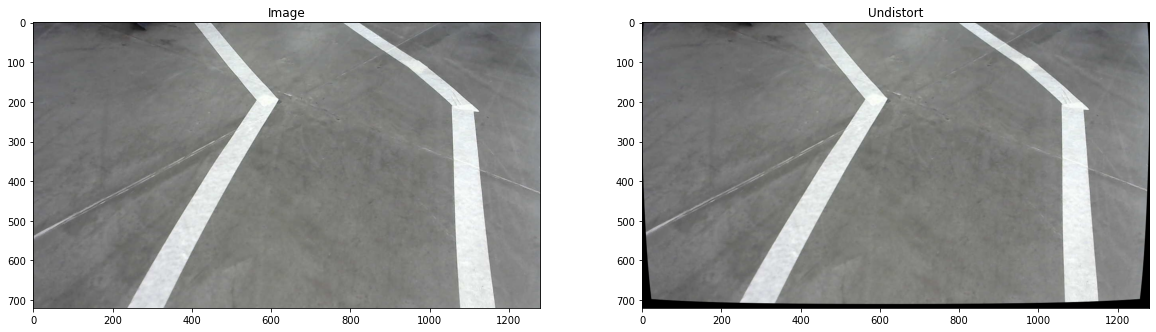

In [6]:
# Reading the image.
img = cv2.imread('laneline/WIN_20230405_09_37_47_Pro.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define all value related to image
width = img.shape[1]
height = img.shape[0]

def undistort(img, cal_dir='chessboard/cal_pickle.p'):
    #cv2.imwrite('camera_cal/test_cal.jpg', dst)
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

undistort = undistort(img)
# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(img, cmap = 'gray');      plt.title('Image');
plt.subplot(1,2,2); plt.imshow(undistort, cmap = 'gray'); plt.title('Undistort');


#### 2.1.2. Create Threshold for Lane Lines

The purpose of creating a threshold is to filter out the noise and emphasize the lane lines for easier detection. The resulting binary image can then be fed into an algorithm to detect the lane lines and estimate their parameters. 

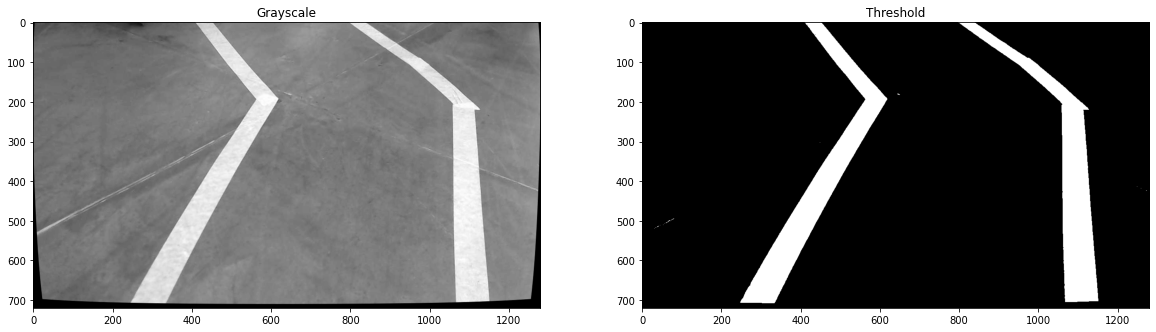

In [7]:
# Convert to grayscale.
gray = cv2.cvtColor(undistort, cv2.COLOR_RGB2GRAY)
# Use global threshold based on grayscale intensity.
threshold = cv2.inRange(gray, 190, 255)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(gray, cmap = 'gray');      plt.title('Grayscale');
plt.subplot(1,2,2); plt.imshow(threshold, cmap = 'gray'); plt.title('Threshold');

#### 2.1.3. Selecting the Region of Interest Using fillPoly()


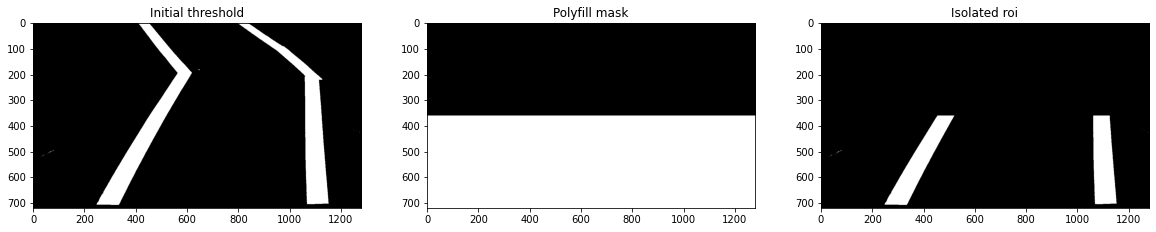

In [8]:
#  Region masking: Select vertices according to the input image.
roi_vertices = np.array([[[width *0/10, height],
                          [width *10/10, height],
                          [width * 10 / 10, height * 5 / 10],
                          [width * 0 / 10, height * 5 / 10]]],dtype=np.int32)

# Defining a blank mask.
mask = np.zeros_like(threshold)   

# Defining a 3 channel or 1 channel color to fill the mask.
if len(threshold.shape) > 2:
    channel_count = threshold.shape[2]  # 3 or 4 depending on the image.
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255

# Filling pixels inside the polygon.
cv2.fillPoly(mask, roi_vertices, ignore_mask_color)

# Constructing the region of interest based on where mask pixels are nonzero.
roi = cv2.bitwise_and(threshold, mask)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,3,1); plt.imshow(threshold, cmap = 'gray'); plt.title('Initial threshold')
plt.subplot(1,3,2); plt.imshow(mask, cmap = 'gray');      plt.title('Polyfill mask')
plt.subplot(1,3,3); plt.imshow(roi, cmap = 'gray');       plt.title('Isolated roi');

#### 2.1.4. Detect Edges and Smooth Noise

In lane detection, the canny() function is commonly used to detect the edges of the lane lines in the original image and create a binary threshold image for further processing. By smoothing the noise in the image and detecting only the strong edges, the canny() function helps to improve the accuracy of the subsequent steps in the lane detection pipeline.

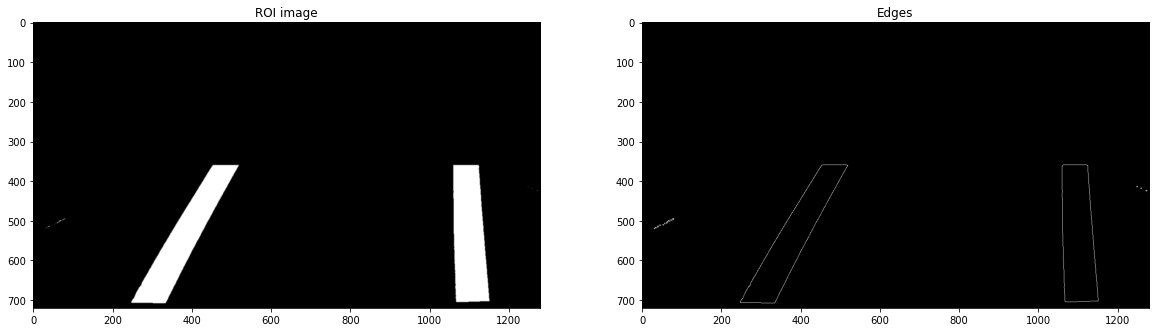

In [9]:
# Smooth with a Gaussian blur.
roi_blur = cv2.GaussianBlur(roi, (3,3), 0)

# Perform Edge Detection.
canny_blur = cv2.Canny(roi_blur, 190, 255)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(roi_blur, cmap = 'gray'); plt.title('ROI image')
plt.subplot(1,2,2); plt.imshow(canny_blur, cmap = 'gray'); plt.title('Edges');

#### 2.1.5. Line Detection Using HoughLinesP()

HoughLinesP() is an OpenCV function used to detect lines in an image using the probabilistic Hough transform algorithm. The function takes a binary image as input and outputs an array of line segments detected in the image. The line segments are represented by their endpoints, which can be used to estimate the parameters of the lines such as slope and intercept. 

Found 5 lines, including: [[365 644 479 429]]


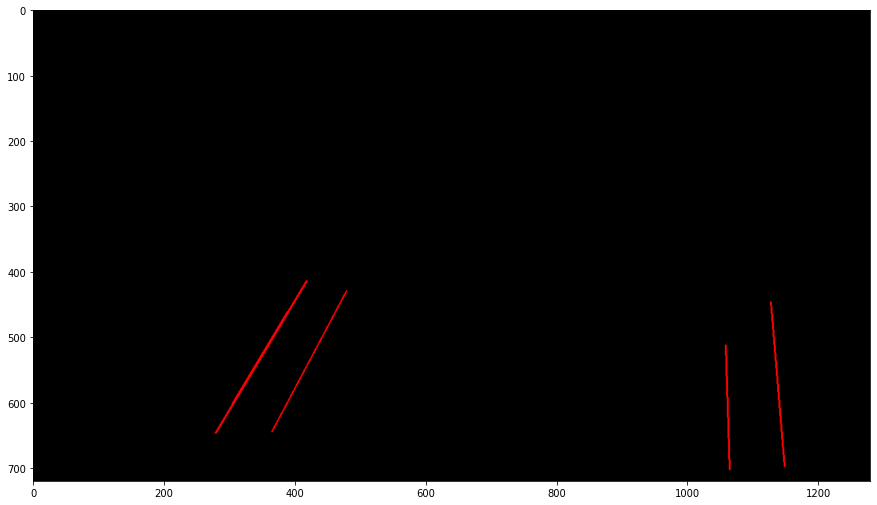

In [10]:
def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    """Utility for drawing lines."""
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Hough transform parameters set according to the input image.
threshold = 90
min_line_len = 100
max_line_gap = 20

lines = cv2.HoughLinesP(
    canny_blur, 1, np.pi / 180, threshold, minLineLength = min_line_len, maxLineGap = max_line_gap)

# Draw all lines found onto a new image.
hough = np.zeros((height, width, 3), dtype = np.uint8)
draw_lines(hough, lines)

print("Found {} lines, including: {}".format(len(lines), lines[0]))
plt.figure(figsize = (15, 10)); plt.imshow(hough);

#### 2.1.6. Separate Sides and Extrapolate

##### <font style='color:rgb(50,120,230)'> a/ Function for separating left and right lines depending on the slope </font>
We have decided not to use slopes as the sole criterion for separating left and right lane lines. This is because in some cases, both left and right lane lines may have an inclination in the same direction, making it difficult to distinguish between them based on slope alone. Instead, based on our experience from testing with real-world scenarios, we have found that the simplest algorithm is the most stable.

To determine whether a given line contributes to the left or right lane lines, we use the lower endpoint of the line, denoted as (x2, y2). Specifically, if the value of x2 is greater than the midpoint of the image (i.e., x = width/2), we consider the line to be part of the right lane. Conversely, if x2 is smaller than the midpoint, we consider it to be part of the left lane. This approach has proven to be effective in practice.

Therefore, if `x2 > width/2` we have right lane, and if `x2 < width/2` we have left lane.

In [11]:
def separate_left_right_lines(lines,width):
    """Separate left and right lines comparing the lower point of the line with the center."""
    left_lines = []
    right_lines = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y1 > y2:
                    x1,y1,x2,y2 = x2,y2,x1,y1
                    
                if x2 < width/2: # Negative slope= left lane.
                    left_lines.append([x1, y1, x2, y2])
                elif x2 > width/2: # Positive slope = right lane.
                    right_lines.append([x1, y1, x2, y2])
    return left_lines, right_lines

separate_left_right_lines(lines,width)


([[479, 429, 365, 644], [389, 461, 305, 601], [418, 414, 279, 646]],
 [[1128, 446, 1149, 697], [1059, 512, 1065, 702]])

##### <font style='color:rgb(50,120,230)'> b/ Function to calculate average which will be used in extrapolating lines </font>
Once the lines are clustered, the next step is to find the most important line for each group by averaging the parameters of the lines (i.e., slope and intercept). This process is called line extrapolation because it involves extending the detected lines beyond their detected endpoints to cover the full length of the lane line.

However, some lane lines may only be partially detected, and therefore, the extrapolation process may result in lines that do not cover the full length of the lane line. To address this issue, the lower and upper border intersections within the region of interest (ROI) are identified to determine the full lane line length. The ROI is usually defined as a trapezoidal region in the image that covers the area where the lane lines are expected to be.

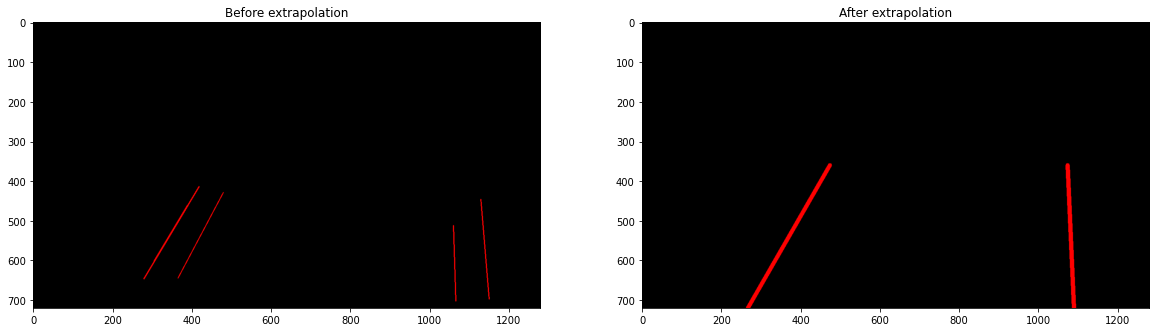

In [12]:
def cal_avg(values):
    """Calculate average value."""
    if not (type(values) == 'NoneType'):
        if len(values) > 0:
            n = len(values)
        else:
            n = 1
        return sum(values) / n
        
def extrapolate_lines(lines, upper_border, lower_border):
    """Extrapolate lines keeping in mind the lower and upper border intersections."""
    slopes = []
    consts = []
    
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            slope = (y1-y2) / (x1-x2)
            slopes.append(slope)
            c = y1 - slope * x1
            consts.append(c)
    avg_slope = cal_avg(slopes)
    avg_consts = cal_avg(consts)
    
    # Calculate average intersection at lower_border.
    x_lane_lower_point = int((lower_border - avg_consts) / avg_slope)
    
    # Calculate average intersection at upper_border.
    x_lane_upper_point = int((upper_border - avg_consts) / avg_slope)
    
    return [x_lane_lower_point, lower_border, x_lane_upper_point, upper_border]

# Define bounds of the region of interest.
roi_upper_border = roi_vertices[0][3][1]
roi_lower_border = roi_vertices[0][1][1]

# Create a blank array to contain the (colorized) results.
lanes_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)

# Use above defined function to identify lists of left-sided and right-sided lines.
lines_left, lines_right = separate_left_right_lines(lines,width)

# Use above defined function to extrapolate the lists of lines into recognized lanes.
lane_left = extrapolate_lines(lines_left, roi_upper_border, roi_lower_border)
lane_right = extrapolate_lines(lines_right, roi_upper_border, roi_lower_border)

if lane_left is not None:
    draw_lines(lanes_img, [[lane_left]], thickness = 10)
    x1_left,y1_left,x2_left,y2_left = lane_left
    if y1_left > y2_left:
        x1_left,y1_left,x2_left,y2_left = x2_left,y2_left,x1_left,y1_left
#lane_left = np.array(lane_left, dtype=np.int32)          

if lane_right is not None:
    draw_lines(lanes_img, [[lane_right]], thickness = 10)
    x1_right,y1_right,x2_right,y2_right = lane_right
    if y1_right > y2_right:
        x1_right,y1_right,x2_right,y2_right = x2_right,y2_right,x1_right,y1_right

# Display results.
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 2, 1); plt.imshow(hough); ax.set_title('Before extrapolation')
ax = fig.add_subplot(1, 2, 2); plt.imshow(lanes_img); ax.set_title('After extrapolation');
plt.show()

#### 2.1.7. Find lane area

In lane detection, the function can be used to fill the space between the left and right lane lines to create a lane area. This is achieved by defining the vertices of the polygon using the endpoints of the lane lines and the bottom corners of the image, and then filling the enclosed region with a desired color. The filled lane area can be overlaid onto the original image for visualization and guidance in driving or autonomous vehicle systems.

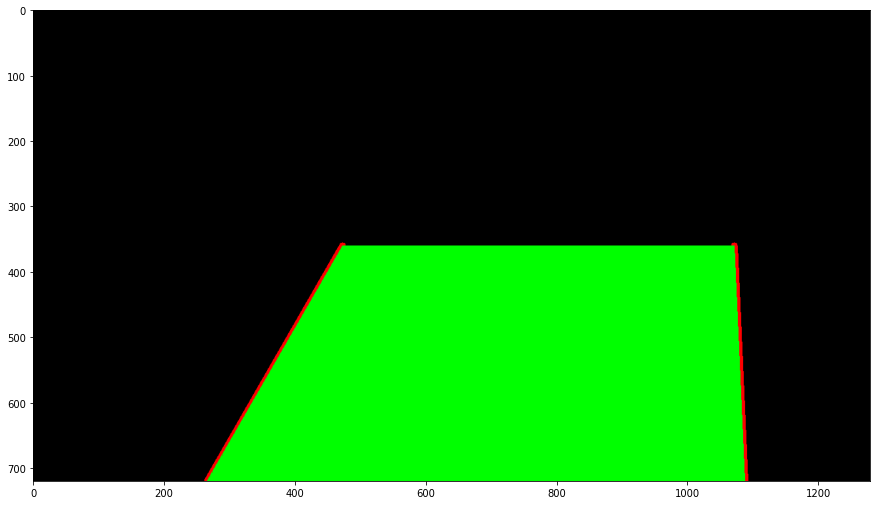

In [13]:
def draw_con(img, lane_right, lane_left):
    """Fill in lane area."""
    points = []
    x1,y1,x2,y2 = lane_right
    points.append([x1,y1])
    points.append([x2,y2])
    
    x1,y1,x2,y2 = lane_left
    points.append([x2,y2])
    points.append([x1,y1])

    points = np.array([points], dtype = 'int32')        
    cv2.fillPoly(img, points, (0,255,0))

if lane_left is not None and lane_right is not None:
    draw_con(lanes_img, lane_right,lane_left)

# Display results.
plt.figure(figsize = (15, 10)); plt.imshow(lanes_img);

### 2.3. Draw midline 

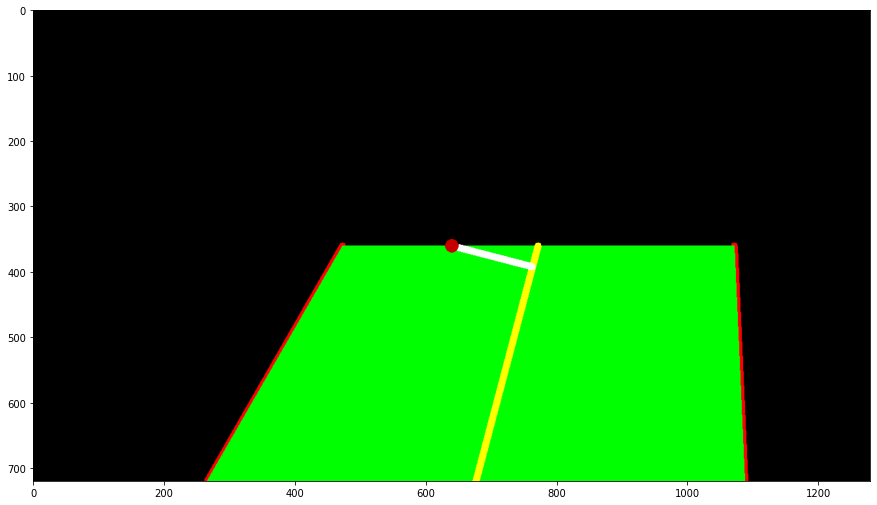

In [14]:
x_mid_line = None
if lane_left is not None and lane_right is not None:# and not np.isnan(lane_left).any() and not np.isnan(lane_right).any():
    midline_x1=int((x1_left + x1_right)/2)
    x_mid_line
    midline_x2=int((x2_left + x2_right)/2)

    cv2.line(lanes_img,(midline_x1,y1_left),(midline_x2,y2_left),(255,255,0),10)
  
distance_img = lanes_img.copy()


"Calculate the distance between the point (px, py) and the vector"
def distance(x1, y1, x2, y2, px, py):
    dx = x2 - x1
    dy = y2 - y1
    numerator = abs(dy * px - dx * py + x2 * y1 - y2 * x1)
    denominator = math.sqrt(dx ** 2 + dy ** 2)
    if denominator == 0: distance = -1
    distance = numerator / denominator

    # Calculate the projection of the point onto the vector
    t = ((px - x1) * (x2 - x1) + (py - y1) * (y2 - y1)) / ((x2 - x1) ** 2 + (y2 - y1) ** 2)
    proj_x = int(x1 + t * (x2 - x1))
    proj_y = int(y1 + t * (y2 - y1))

    return distance, (proj_x, proj_y)

center_point = (int(img.shape[1]/2), int(img.shape[0]/2))   
if midline_x1 is not None:
    d, proj_point = distance(midline_x1, y1_left, midline_x2, y2_left, center_point[0], center_point[1])

    #Draw midline of lanelines
    cv2.line(lanes_img,center_point, proj_point,(255,255,255),10)

    # Draw center point of image
    cv2.circle(lanes_img,center_point,5,(200,0,0),10)

# Display results.
plt.figure(figsize = (15, 10)); plt.imshow(lanes_img);

#### Blend result together

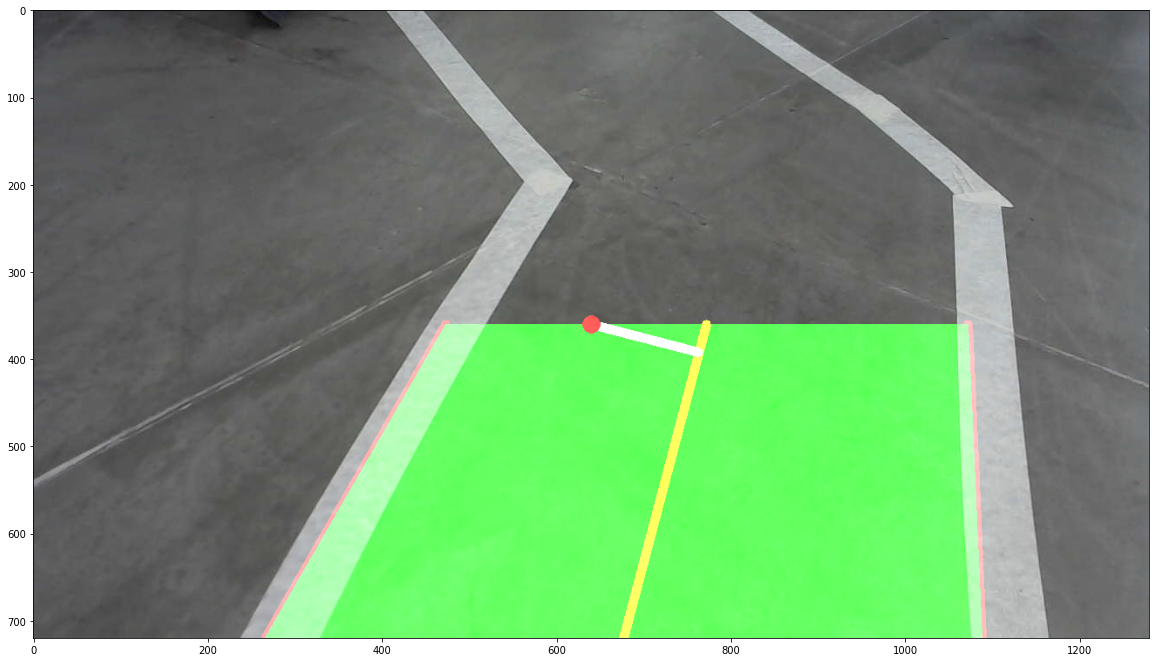

In [15]:
new_img = img
image_annotated = cv2.addWeighted(img, 0.8, lanes_img, 1, 0)
# Display the results, and save image to file.
fig = plt.figure(figsize = (20, 20))
plt.imshow(image_annotated)
#image_annotated = cv2.cvtColor(image_annotated, cv2.COLOR_BGR2RGB)

### 2.3: Find the camera position:

<img src="https://i.imgur.com/GjxG0Nx.png" width="500" height="500">

Suppose we have a 3D space, call the plane containing the road is base plane, and the road view we see on the image is image region. Suppose that center point of the image is  $O$ , the projection point of camera to the base plane is  $P$ . line $OP$  intersect the image region at lower border, call that intersect is point  $L$ . Call  $Pd$  is the projection of  $P$  to the midline. Call  $O′,L′,P′$ . The figure below illustrates this situation.

If we ignore the height, the distance from camera to midlines is also the length of line  $PD$ . To solve this problem, we can flat the 3D space to image Now we can work with only image plane

<img src="https://i.imgur.com/vwzxKto.png" width="500" height="500">

#### 2.3.1 Calulate  $PP′ $

We want to have the value of  $PP'$ , the solution is to find the value of  $OO',LL',OL,LP $

Find the vlue of  $OL,LP$ 

We assume that the camera is fixed, so OL an LP must be also fixed as it is correlate with the change of camera. So to get the distance of OL and LP easily, we can simply measure it in the real world

#### 2.3.2 Find the value of  $OO′,LP$ 

With the same x coordinate, ratio of pixel and milimeters is unchange for any pairs of  $y1,y2$ , Using this feature, we can determine the distance in milimeters of  $OO′,LL'$,  as each lines is located on same $x$ coordinate.

<img src="https://i.imgur.com/wM8K9sv.png" width="500" height="500">

With the measurement, we will have the ratio (mm/pixel) of pixel and milimeters at lower border axis and center axis. So the value of the these distance: $real distance = ratio * pixel$

Once we have the values of all the required distances, we can use the Thales theorem to find  $PP′$ .

Call A is the intersect point of midline and OL 

$\frac{AL}{LO}=\frac{LL'}{OO'}=>AO=\frac{OL}{\frac{LL'}{OO'}-1}\\
\frac{AO}{AO+OL+LP}=\frac{OO'}{PP'}=>PP'=\frac{OO'*(AO+OL+LP)}{AO}$

#### 2.3.3 calulcate  $PP_d$ 

$PPd=PP′sin(L′P′D^)$ . This means that the sine of the angle between the midline and the horizontal axis is equal to the ratio of  $PP_d$  and  $PP′$ . We can use this to find the distance of the camera.

#### 2.3.4 Accuracy of the algorithm

To determine the accuracy of the robot’s distance measurements, we positioned the camera at specific locations and recorded the distances calculated by the robot. These measurements were then compared to the actual distances that we had previously established. The data collected was stored in a file called “accuracy of distance measurement.csv” and is analyzed below.

In [16]:
import pandas as pd
data = pd.read_csv("accuracy of distance measurement.csv")
data['accuracy'] = 1 - abs((data['real distance']-data['calcultated distance']) / data['real distance'])
print(data)
print("mean:",data.accuracy.mean())
print("standard devitation:",data.accuracy.std())

    real distance real part  calcultated distance calculated part  accuracy
0              10     right                  4.21            left  0.421000
1              10      left                 12.31            left  0.769000
2              20    right                  16.59           right  0.829500
3              20      left                 24.23            left  0.788500
4              40     right                 39.91           right  0.997750
5              40      left                 45.94            left  0.851500
6              80     right                 92.32           right  0.846000
7              80      left                 94.51            left  0.818625
8             160     right                229.13           right  0.567937
9             160      left                243.23            left  0.479813
10            320     right                448.24           right  0.599250
11            320      left                   NaN             NaN       NaN
mean: 0.7244

As shown on above table, our algorithm work well if the real distance of the camera is not too near the midlines and if the camera is not futher than 80mm. the meadian accuracy is 72.44 and the standard deviation is 0.1799

### 2.4: The final result of every above task:
We have taken the result of the processing on jetson nano, and store the result as a video of moving on the road. The result video was recorded names "Task 2 result video.mp4". You can take a look at it.

In [21]:
from moviepy.editor import *
clip = VideoFileClip('result.mp4')
clip.ipython_display(width = 800)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### TASK 3: Deploy your program on JETSON NANO

Before running the code on Jetson Nano, make sure that the following libraries are installed: numpy, opencv-python, Jetson.GPIO, and math. You will need two files to run the code: “function.py”, which contains all the necessary functions, and “main.py”, which initializes the video capture and applies operations on the captured frame. Connect the GPIO pins of the Jetson Nano (37, 35, 33, 31) to in1, in2, in3, and in4 of the LM298 respectively. Then, open the command prompt and navigate to the directory containing these two files. Type “python3 main.py” to run the code. To stop the code, select the cv2 imshow window and press the ‘q’ button.


### TASK 4: Metric rectification - Laneline distance

In this task, we need to measure the distance between the lane markings. To measure distance in the real world based on distance in a 2D image, we would need to know the scale factor or conversion ratio between the two dimensions. This can be determined by measuring a known distance in both the image and the real world. 

Therefore we utilize the chessboard in camera calibration that has a known dimension of each square `(d_mm = 22.35 mm)` in real world. Then we count the pixel dimension of each square in the image by:
- Use `cv2.warpPerspective()` to warp the image to make the lane lines appear parallel and equally spaced throughout the image. 
- Apply `cv2.findChessboardCorners()`to to detect the corners of the chessboard squares in the image. 
- Measure the pixel distance `(d_pixel)` between two adjacent corners of a known square on the chessboard to get the number of pixels along one of its edges.
- Calculate the conversion ratio by dividing the size of the known square in pixels by its size in millimeters: `conversion_ratio = d_pixel / d_mm`

====> Run the 'Task 4_Supporting File (Ratio Conversion).ipynb' file to obtain this conversion ratio. The more detailed is also located at this code file. 

[266 720 473 360]
[1088  720 1072  360]


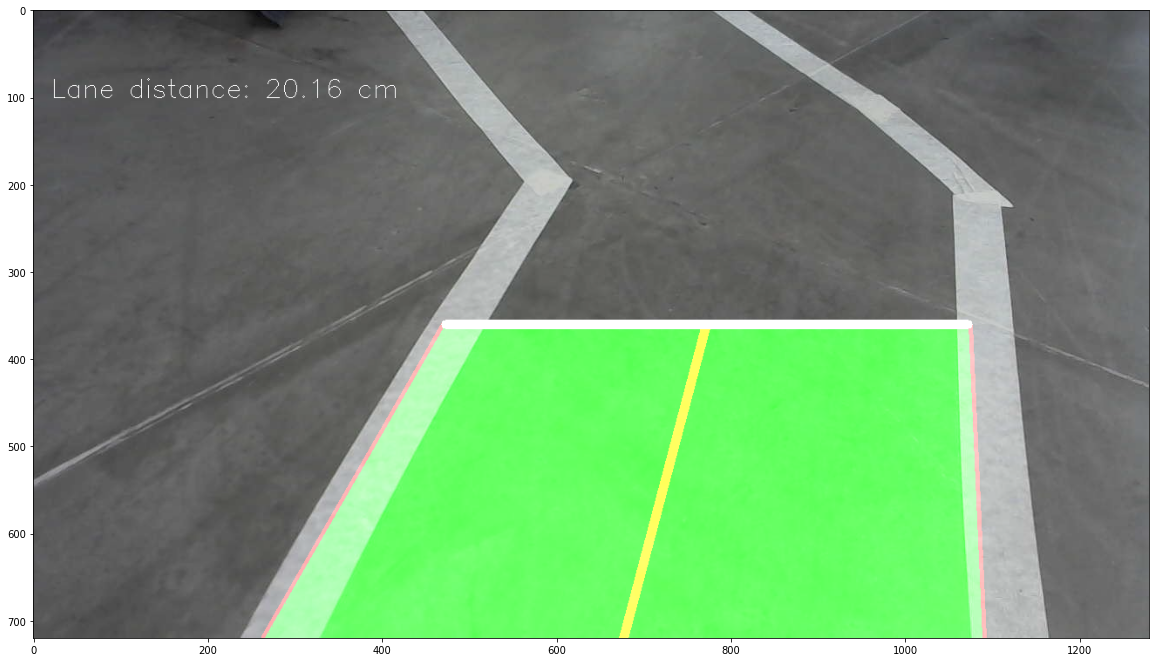

In [20]:
#Take the conversion ratio from "Task 4_Laneline Distance.ipynb" code
RATIO = 2.83686193447649 

def twolane_distance(lane_left, lane_right, RATIO): 
    d_pixel = (abs(lane_right[0] - lane_left[0]) + abs(lane_right[2] - lane_left[2]))/2
    print(lane_left)
    print(lane_right)

    d_mm = d_pixel * RATIO
    return d_mm

d_lane = twolane_distance(lane_left, lane_right, RATIO) 
lane_right = np.array(lane_right,dtype=np.int32)
lane_left = np.array(lane_left,dtype=np.int32)

cv2.line(distance_img,(int(lane_left[2]),int(lane_left[3])),(int(lane_right[2]),int(lane_right[3])),(255,255,255),10)
cv2.putText(distance_img, "Lane distance: " + str(round(d_lane/100,2)) + ' cm', (20,100), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color= (255, 255, 255), lineType=2)
image_annotated = cv2.addWeighted(new_img, 0.8, distance_img, 1, 0)
# Display the results, and save image to file.
fig = plt.figure(figsize = (20, 20))
plt.imshow(image_annotated)